In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import lhsmdu
import os
import pdspy.modeling as modeling

%matplotlib inline

In [2]:
# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.047s


In [3]:
with open ('../grid_metadata/grid714_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)
with open ('../grid_metadata/grid714_seds.txt', 'rb') as fp:
    slicevals = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/grid714_seds.txt', 'rb') as fp:
    nanslicevals = np.array(pickle.load(fp))[:,100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    if -np.inf in slicevals[i]:
        a = slicevals[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = slicevals[i][ind]
        for j in range(ind):
            slicevals[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=1)[:,np.newaxis]

fitdata=[]
for i in range(len(slicevals)):
    data=[coords[0][i],coords[1][i]]
    coeffs=pca.transform(slice_seds_msub[i].reshape(1,-1))
    for j in range(15):
        data.append(coeffs[0][j])
    fitdata.append(data)
fitdata=np.array(fitdata)

In [4]:
def show_surface(weight):
    print(str(weight))
    plt.figure(figsize=(7,6))
    beta=fitdata[:,0]
    incl=fitdata[:,1]
    w0=fitdata[:,2+weight]
    style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
    plt.scatter(beta,incl, c=w0, s=50, **style)
    plt.xlabel("beta")
    plt.ylabel("incl")
    plt.colorbar()
    plt.show()

0


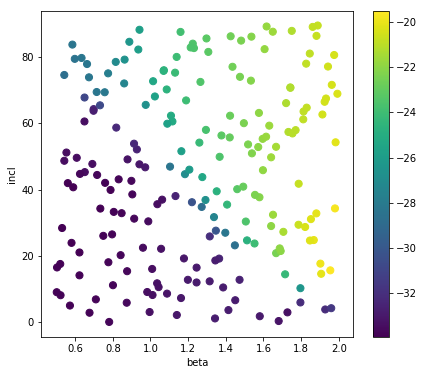

1


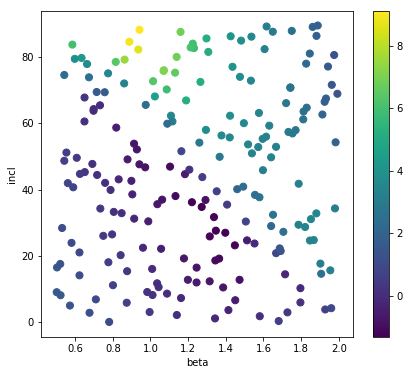

2


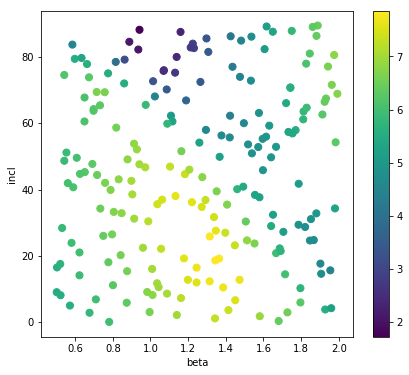

3


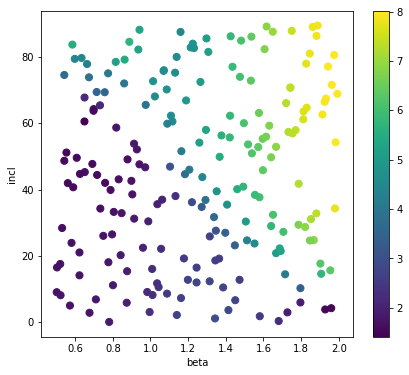

4


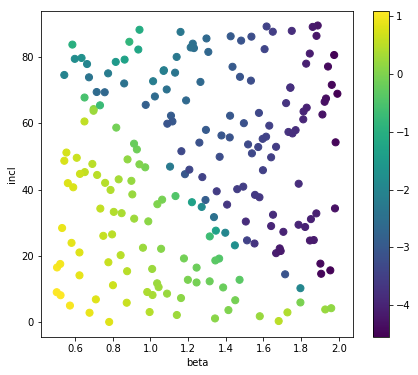

5


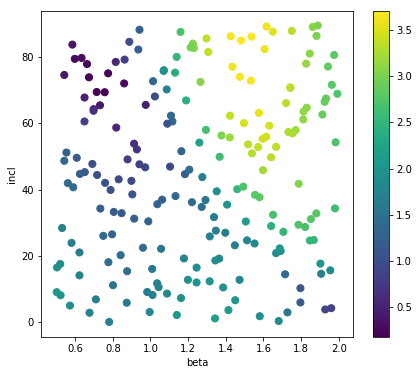

6


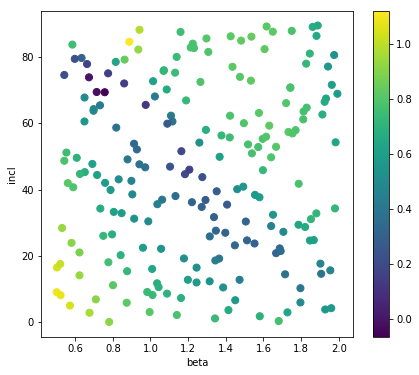

7


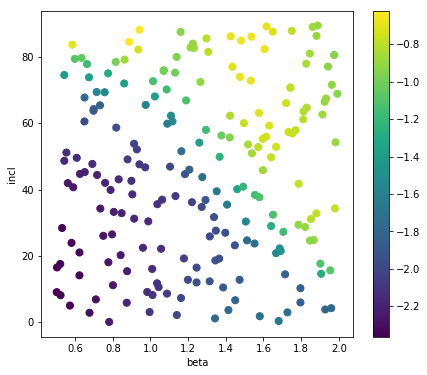

8


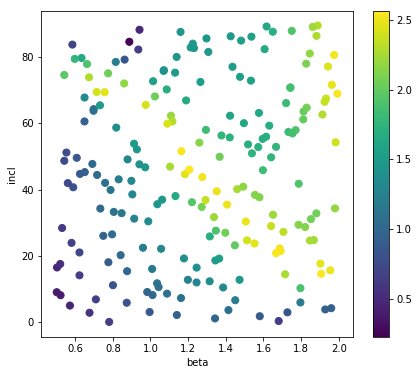

9


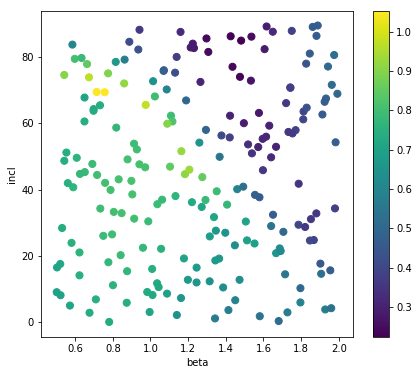

In [22]:
for i in range(10):
    show_surface(i)

In [6]:
sample=[]
for i in (0,1,2,3,4,5,6,7,8,9,9.9):
    sample.append(np.array([0,10,20,30,40,50,60,70,80,90,99])+[1000*i])
sample=np.array(sample).flatten()
sample=np.ndarray.tolist(sample)
sample=list(map(int,sample))

Initial ln-likelihood: -507.88
[ 2.62455408 -1.83258146  6.43775165]
[ 3.71462243  0.4        25.        ]


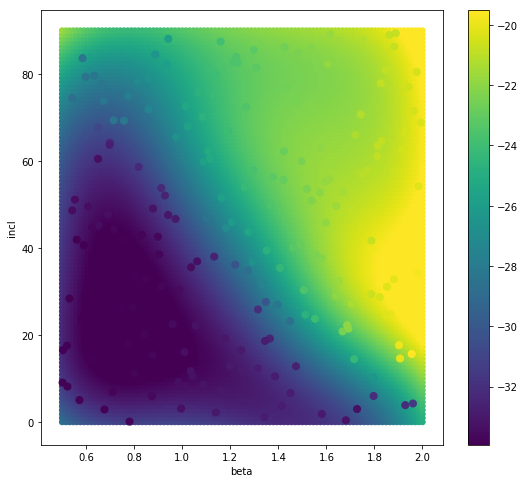

In [12]:
weight=0
w0=fitdata[:,2+weight]

x=np.transpose(coords)
yerr=0.1*w0
kernel = np.var(w0) * kernels.ExpSquaredKernel(0.4**2,ndim=2,axes=0)*kernels.ExpSquaredKernel(25**2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

np.set_printoptions(suppress=True)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(0.5, 2.0, 100),np.linspace(0, 90, 100))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(9,8))
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30,**style)
plt.colorbar()
plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style)#,edgecolors='r')

style = dict(cmap='magma', vmin=np.min(pred_var), vmax=np.max(pred_var))
#plt.scatter(np.array(x_pred)[sample,0], np.array(x_pred)[sample,1], c=pred_var[sample], s=20, **style)
#plt.colorbar()

plt.ylabel("incl")
plt.xlabel("beta")

plt.show()

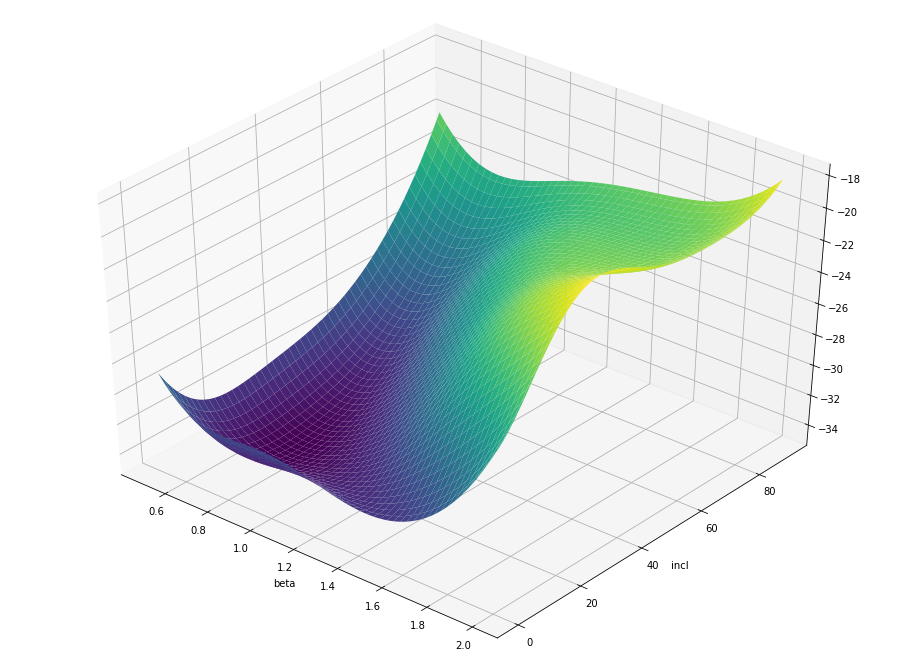

In [13]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.

surf = ax.plot_surface(np.array(x_pred)[:,0].reshape(100,100),np.array(x_pred)[:,1].reshape(100,100),pred.reshape(100,100),cmap=cm.viridis)
ax.set_xlabel("beta")
ax.set_ylabel("incl")
ax.view_init(40, 310)
plt.show()

      fun: 441.3827332079672
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([ 0.00000093, -0.00000056, -0.00000028])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([5.45944441, 0.66220423, 7.5226181 ])

Final ln-likelihood: -441.38
[15.32862823  1.39250198 43.00468441]


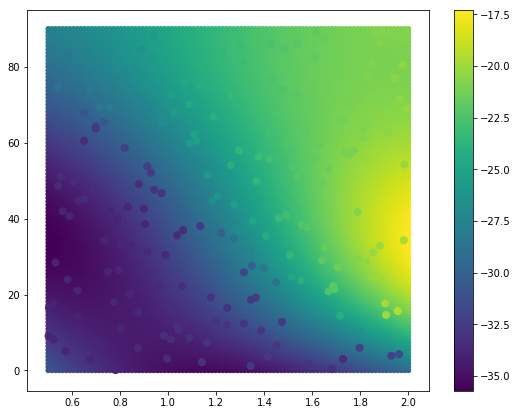

In [17]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(w0)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(w0)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))

print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=20, **style)
plt.colorbar()
plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style)#,edgecolors='r')

style = dict(cmap='magma', vmin=np.min(pred_var), vmax=np.max(pred_var))
#plt.scatter(np.array(x_pred)[sample,0], np.array(x_pred)[sample,1], c=pred_var[sample], s=20, **style)
#plt.colorbar()


plt.show()

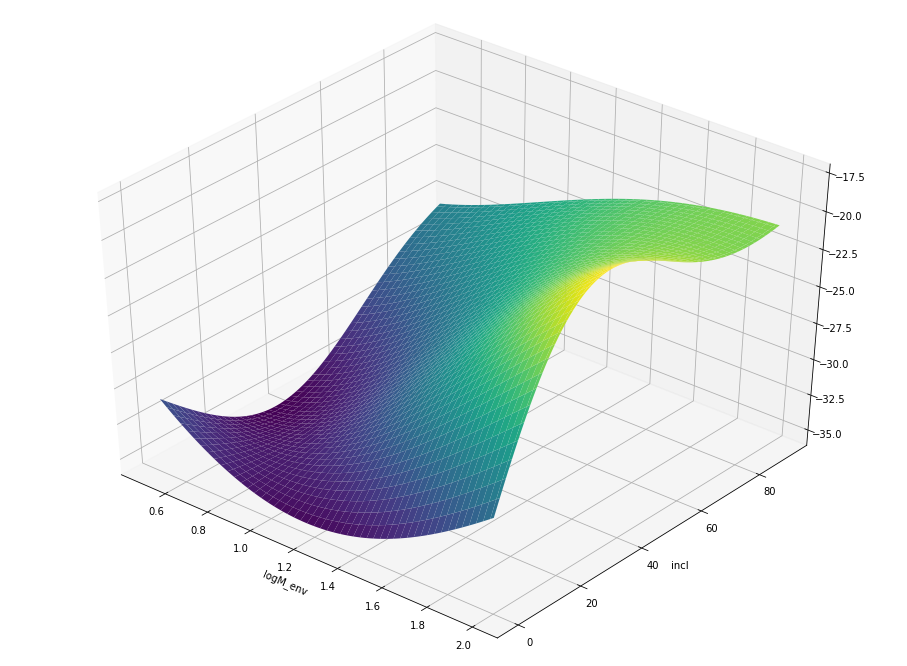

In [18]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.

surf = ax.plot_surface(x0pred,x1pred,pred.reshape(100,100),cmap=cm.viridis)
    
ax.set_xlabel("logM_env")
ax.set_ylabel("incl")
ax.view_init(40, 310)
plt.show()


In [5]:
def ret_bix(beta, incl, theta):
    beta_incl_x = beta*np.cos(theta) + incl*np.sin(theta)
    return (beta*np.cos(theta)) + (incl*np.sin(theta))
def ret_biy(beta, incl, theta):
    beta_incl_y = -beta*np.sin(theta) + incl*np.cos(theta)
    return (-beta*np.sin(theta)) + (incl*np.cos(theta))

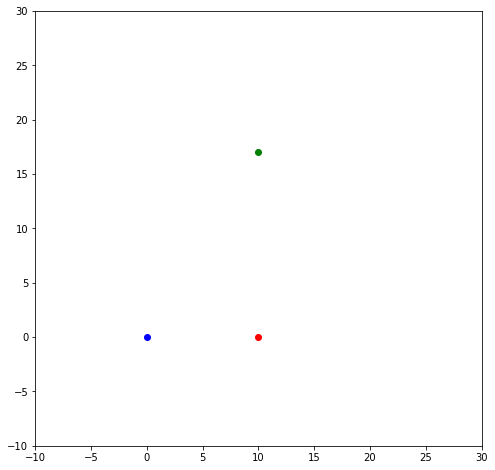

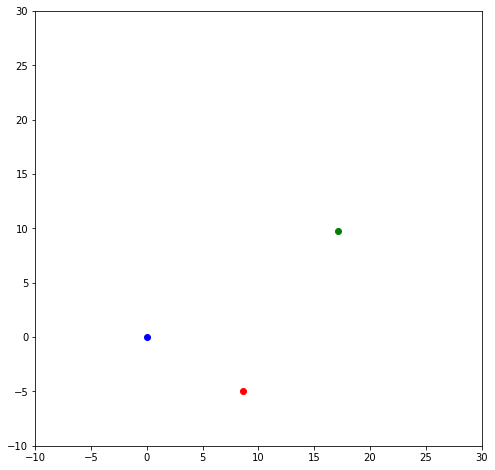

In [65]:
points=np.array([[0,0],[10,0],[10,17]])
pointsrot=[]
theta=np.pi/6
for i in range(3):
    x=points[i][0]*np.cos(theta)+points[i][1]*np.sin(theta)
    y=-1*points[i][0]*np.sin(theta)+points[i][1]*np.cos(theta)
    pointsrot.append([x,y])
    

plt.figure(figsize=(8,8))
plt.scatter(points[0,0],points[0,1],c="b")
plt.scatter(points[1,0],points[1,1],c="r")
plt.scatter(points[2,0],points[2,1],c="g")
plt.ylim(-10,30)
plt.xlim(-10,30)
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(np.array(pointsrot)[0,0],np.array(pointsrot)[0,1],c="b")
plt.scatter(np.array(pointsrot)[1,0],np.array(pointsrot)[1,1],c="r")
plt.scatter(np.array(pointsrot)[2,0],np.array(pointsrot)[2,1],c="g")
plt.ylim(-10,30)
plt.xlim(-10,30)
plt.show()

In [15]:

beta=fitdata[:,0]
incl=fitdata[:,1]

beta[1]

0.787807336455735

In [68]:

def calc_bi_coordinates(theta):
    bix=[]
    biy=[]
    for i in range(len(beta)):
        bix.append(ret_bix(beta[i],incl[i],theta))
        biy.append(ret_biy(beta[i],incl[i],theta))
    return bix, biy

0


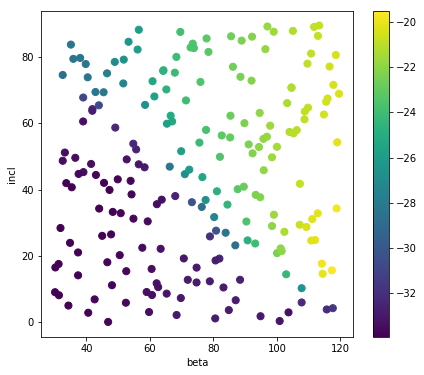

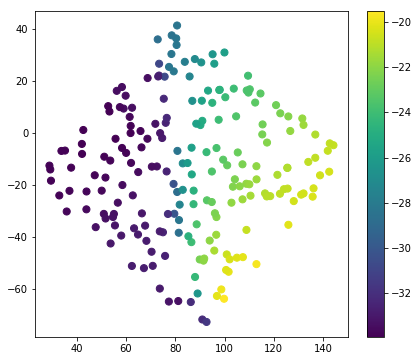

1


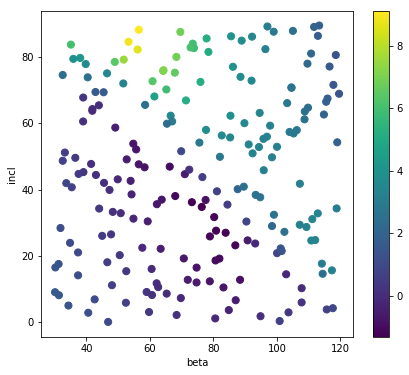

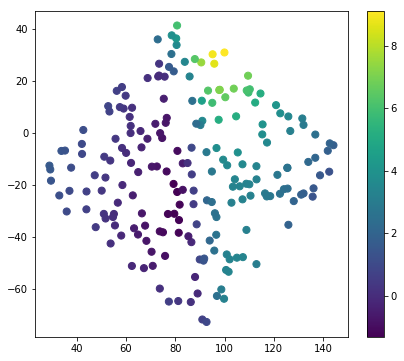

2


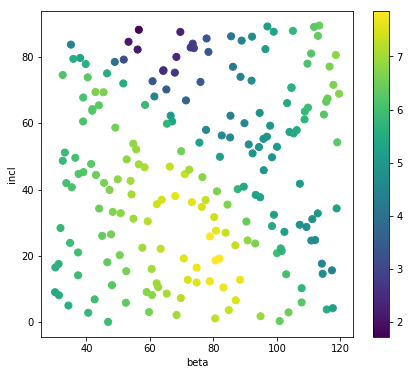

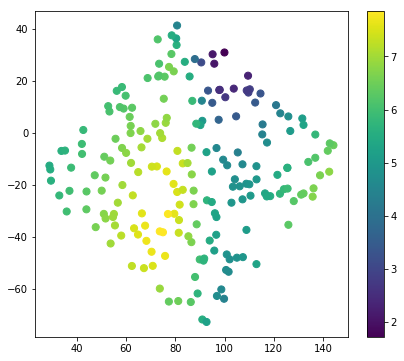

3


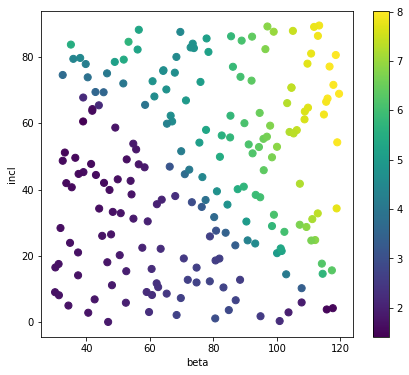

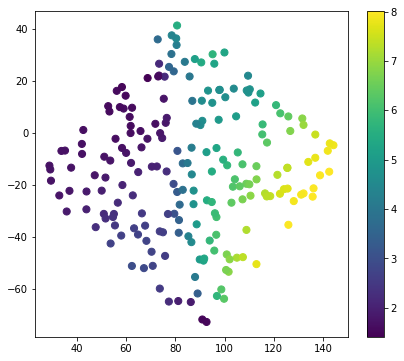

4


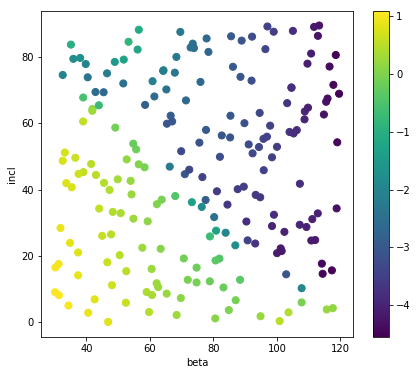

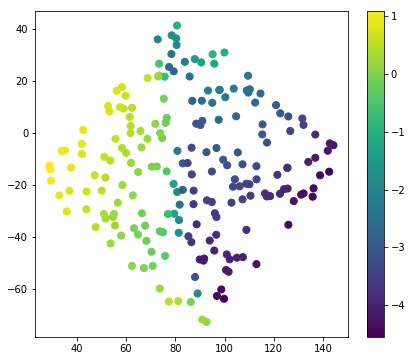

5


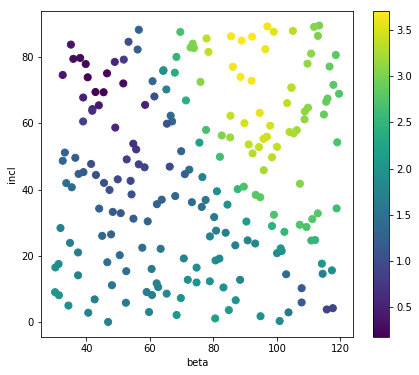

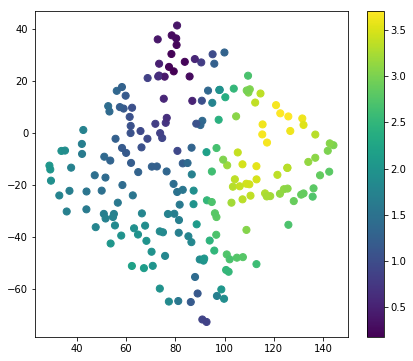

6


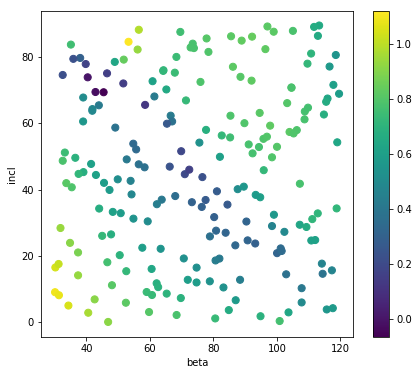

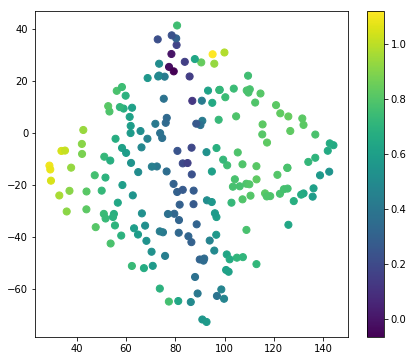

7


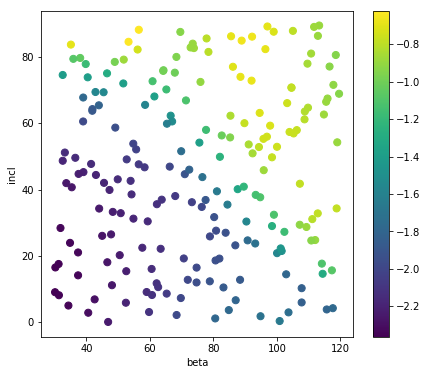

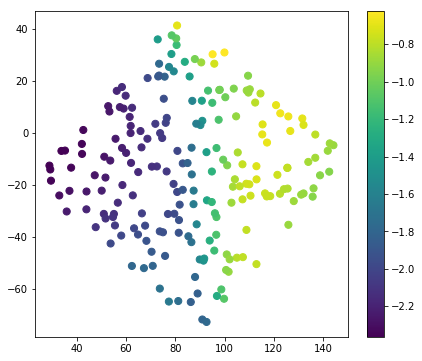

8


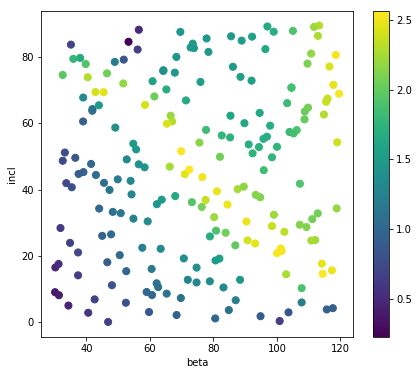

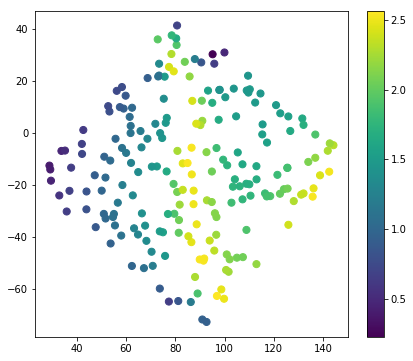

9


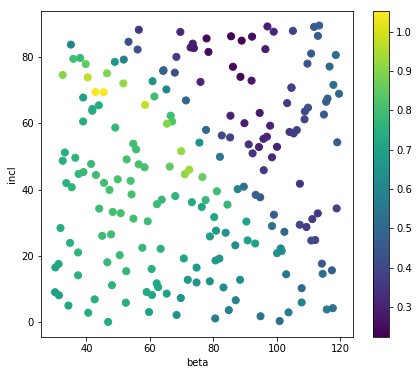

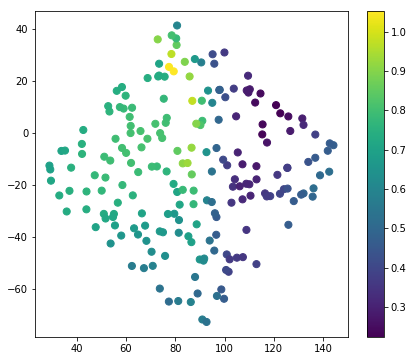

In [70]:
for weight in range(10):
    print(weight)
    plt.figure(figsize=(7,6))
    beta=fitdata[:,0]*90/1.5
    incl=fitdata[:,1]
    w0=fitdata[:,2+weight]
    style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
    plt.scatter(beta,incl, c=w0, s=50, **style)
    plt.xlabel("beta")
    plt.ylabel("incl")
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(7,6))
    a,b=calc_bi_coordinates(.7)
    plt.scatter(a,b, c=fitdata[:,2+weight], s=50, **style)
    plt.colorbar()
    plt.show()

In [34]:
theta=0.7
def x(i):
    return beta[i]
def y(i):
    return incl[i]
for i in range(200):
    print(x(i)*np.cos(theta)+y(i)*np.sin(theta),-x(i)*np.sin(theta)+y(i)*np.cos(theta))
    

30.81892366327258 35.0807423362215
26.287287482696986 29.986477400858547
5.395752602589319 4.154841959855574
25.47179974669397 27.79008130211283
39.40577718794367 44.25226649462297
23.361264643189884 25.760780840814498
38.64613114403278 43.13316885356684
45.873797375630886 51.3695019487771
19.933512582950762 21.118748057376262
51.632501634390046 59.96148847511002
1.77854547568441 0.027132669399988374
51.1163421892264 57.67117756032405
26.652106386996476 30.727361944815335
56.071174056283766 64.55607337914267
39.78521693764445 44.91221195806497
16.479890774693683 17.155313033323555
59.03726740288488 67.16000480236454
36.820272579610396 41.237134746849414
32.38882192203667 37.509302353761946
11.02943560130252 12.313170008943608
24.61167796557643 27.571679830099505
8.959434229207886 8.596729271433754
11.57835830145067 10.710995429229973
17.35198498575437 19.437893741979288
23.61577158668605 24.963753901678576
11.716424119503982 13.102300734028221
22.04200172140866 24.919655571072433
25.51

In [37]:
beta[0]

0.9719782899491127

In [38]:
incl[0]

46.685327425507616